### Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

## 1. Importing the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

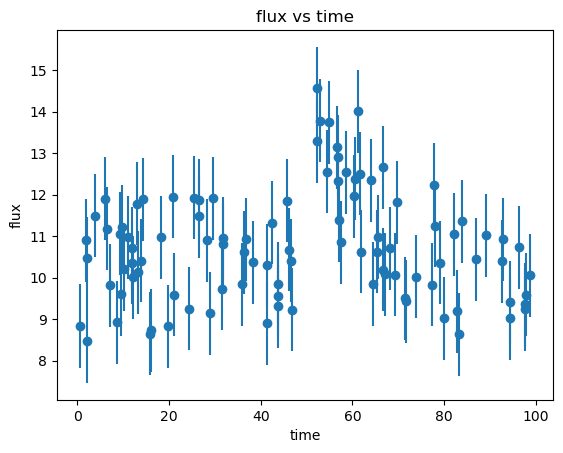

In [2]:
data = np.load('transient.npy')
plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o")
plt.xlabel('time')
plt.ylabel('flux')
plt.title('flux vs time')
plt.show()

# 2. Ploting the first function over the data
The values of the parameters are simply decided by what seems to work best, they're not decisive.


$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$ where $\alpha = 1 /2\sigma_W^2$

In [35]:
burst_t_0 =  50
burst_b = 10
burst_A = 14
burst_alpha = 0.5
init_burst = np.array([burst_t_0, burst_b, burst_A, burst_alpha])

init_gauss = np.array([burst_t_0, burst_b, 14, 0.2])

def burst(parameters, t):
    t_0, b, A, alpha  = parameters
    if (t < t_0): return b
    else: return b + A * np.exp(-alpha * (t - t_0))

def gauss_profile(parameters, t):
    t_0, b, A, alpha  = parameters
    return b + A * np.exp(- alpha * (t - t_0)**2)

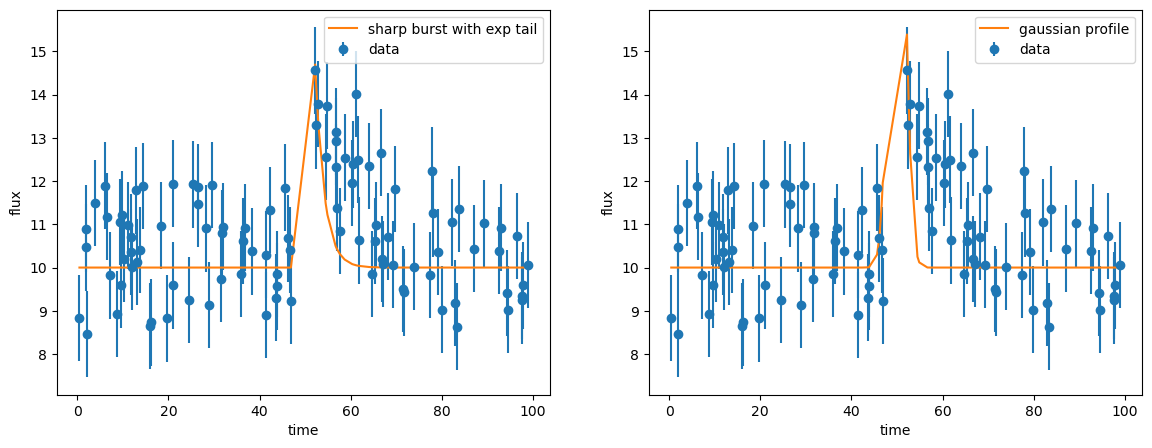

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o", label = 'data')
y_burst = [burst(init_burst, data[i, 0]) for i in range(len(data[:, 0]))]
ax[0].plot(data[:, 0], y_burst, label = 'sharp burst with exp tail')

ax[1].errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o", label = 'data')
y_gauss = [gauss_profile(init_gauss, data[i, 0]) for i in range(len(data[:, 0]))]
ax[1].plot(data[:, 0], y_gauss, label = 'gaussian profile')

for i in range(2):
    ax[i].legend()
    ax[i].set(xlabel= 'time', ylabel = 'flux')
plt.show()

## 3. Nested sampling

Firstly we have to set our priors. We know them for the burst model case, but not for the gaussian profile. By playing with them in the plot above, we know that b and t$_0$ will have to stay the same, as they determine the start and end of the rise. If we want A to be within the same limits, we have to reduce alpha and we can see that limiting it to be < 2 seems to fit the curve correctly.

In [37]:
import dynesty

ndim = 4 #dimention of the parameter space (t0, b, A, alpha)

#range of our parameters
t_0min, t_0max = 0, 100
bmin, bmax = 0,50
Amin, Amax = 0,50
alphamin, alphamax = np.exp(-5),np.exp(5)
sigmaWmin, sigmaWmax = np.exp(-2), np.exp(2)

In [41]:
import scipy

def burst(parameters, x):
    t_0, b, A, alpha = parameters
    y = []
    for i in range(len(x)):
        if (x[i] < t_0): y.append(b)
        else: y.append(b + A * np.exp (-alpha * (x[i] - t_0)))
    y = np.array(y)
    return y

def loglikelihood (parameters, data, model=burst):
    x, y, sigma_y = data.T
    
    if model == 'burst': y_fit = burst(parameters, x)
    elif model == 'gauss_profile': y_fit = gauss_profile(parameters, x)
        
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 )

#we have a uniform distribution on A, b, t0 and 1/alpha
#if we go to a log prior we have a constant in A, b and t_0 which we put to zero
#and a log(alpha)
#but what we actually need isn't the prior itself, but a function that transforms samples from the unit 4dcube to the target prior
#meaning we have a number which is distributed uniformly in 4d between 0, 1
def ptform(u, model):
    x = np.array(u)
    #t_0 = x[0] uniform in 0,100
    #b = x[1] uniform in 0,50
    #A = x[2] uniform in 0,50
    #alpha = x[3]  ln(alpha) uniform in -5, 5

    #transforming t_0:
    x[0] = scipy.stats.uniform.ppf(u[0], loc = t_0min, scale = t_0max - t_0min)

    #transforming b
    x[1] = scipy.stats.uniform.ppf(u[1], loc = bmin, scale = bmax - bmin)

    #transforming A
    x[2] = scipy.stats.uniform.ppf(u[2], loc = Amin, scale = Amax - Amin)

    #transforming alpha
    if model == 'burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        
    return x

[see dynesty documentation: ](https://dynesty.readthedocs.io/en/latest/faq.html)Larger numbers result in a more finely sampled posterior (more accurate evidence), but also a larger number of iterations required to converge. Default is 500.


dynesty documentation recommends to use at least 50 * ndim live points, so we will start by using 250 to be sure. 

After running, we got a warning suggesting to either:
- add more live points
- different samples
- disable bootstrap

in order to have more efficient sampling. We will try to use 400 live points. We found that it gives less warnings! I finally go to 500, not larger as the execution time is starting to be a bit too much and the results seem to hold well. 

In [51]:
sampler = dynesty.NestedSampler(loglikelihood, ptform, ndim, logl_args=[data,'burst'],ptform_args=['burst'], nlive = 500)
sampler.run_nested()
sresults = sampler.results

3923it [03:40,  2.82it/s, bound: 96 | nc: 87 | ncall: 89701 | eff(%):  4.373 | loglstar:   -inf < -86.563 <    inf | logz: -93.354 +/-  0.107 | dlogz: 36.222 >  0.509]      C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3941it [03:50,  5.03it/s, bound: 101 | nc: 118 | ncall: 93502 | eff(%):  4.215 | loglstar:   -inf < -86.453 <    inf | logz: -93.341 +/-  0.107 | dlogz: 36.173 >  0.509]C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is 

In [52]:
from dynesty import plotting as dyplot

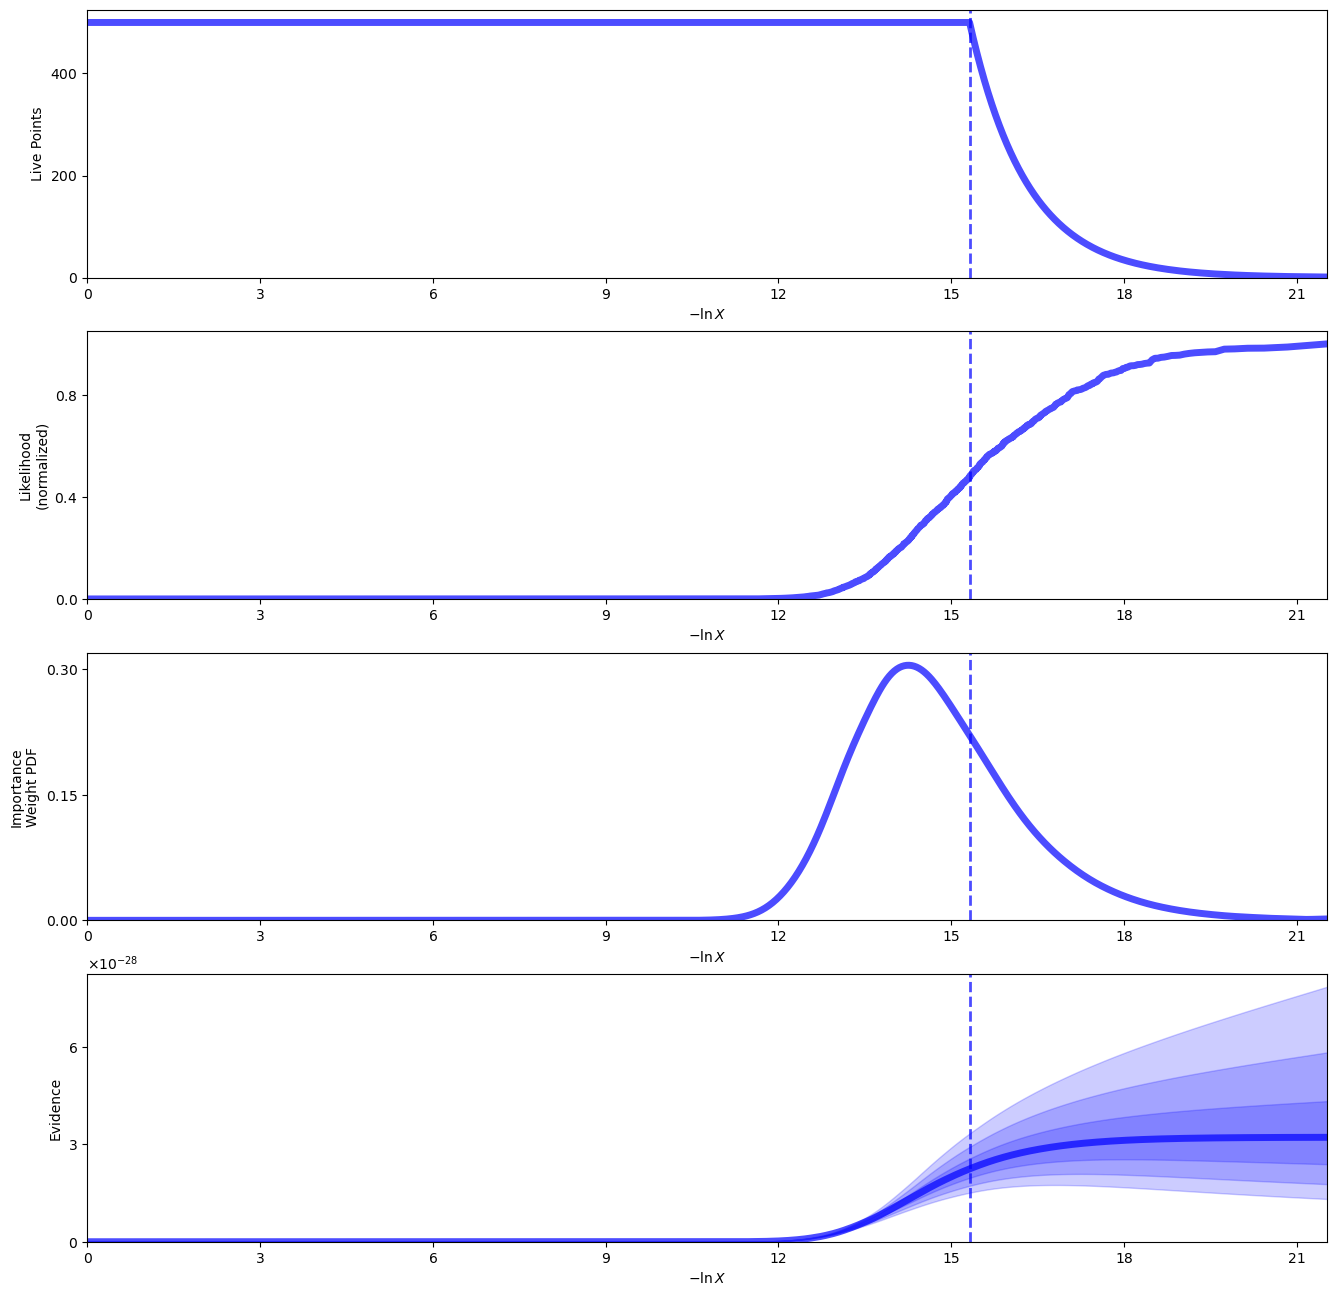

In [53]:
rfig, raxes = dyplot.runplot(sresults)

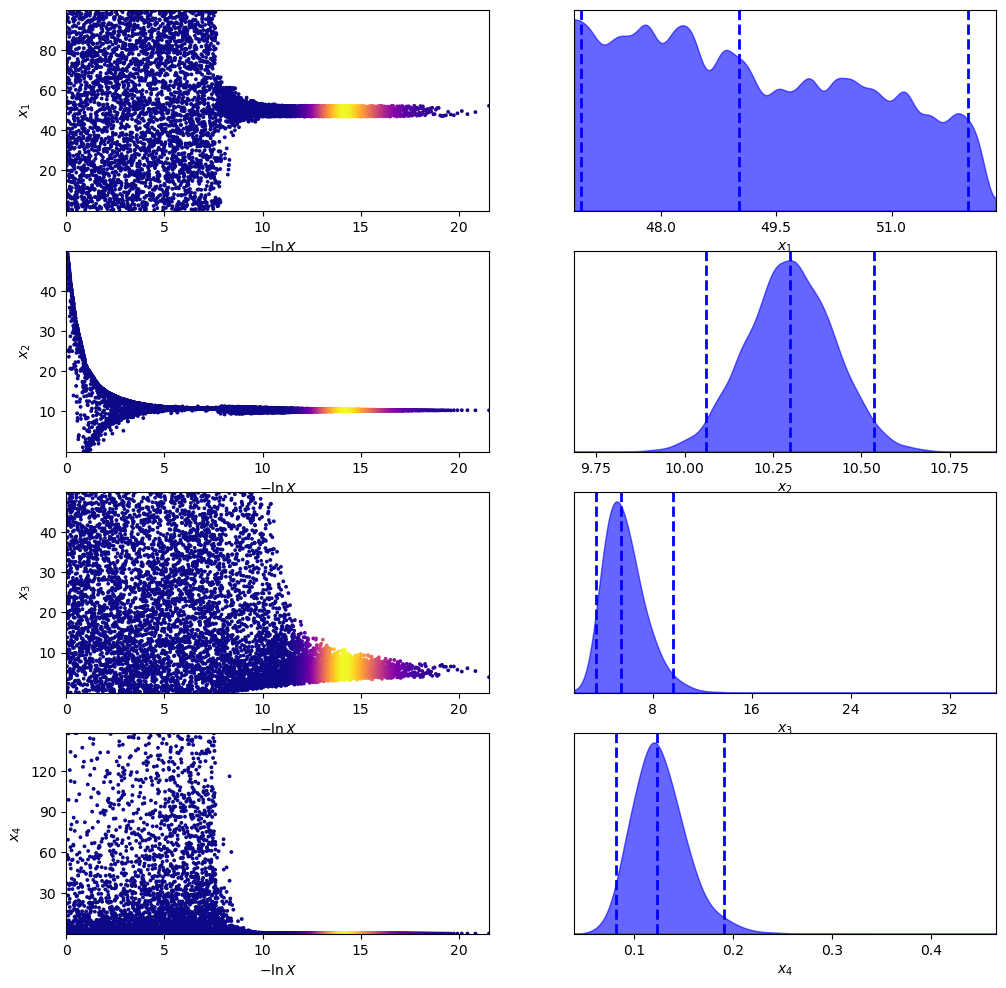

In [54]:
tfig, taxes = dyplot.traceplot(sresults)

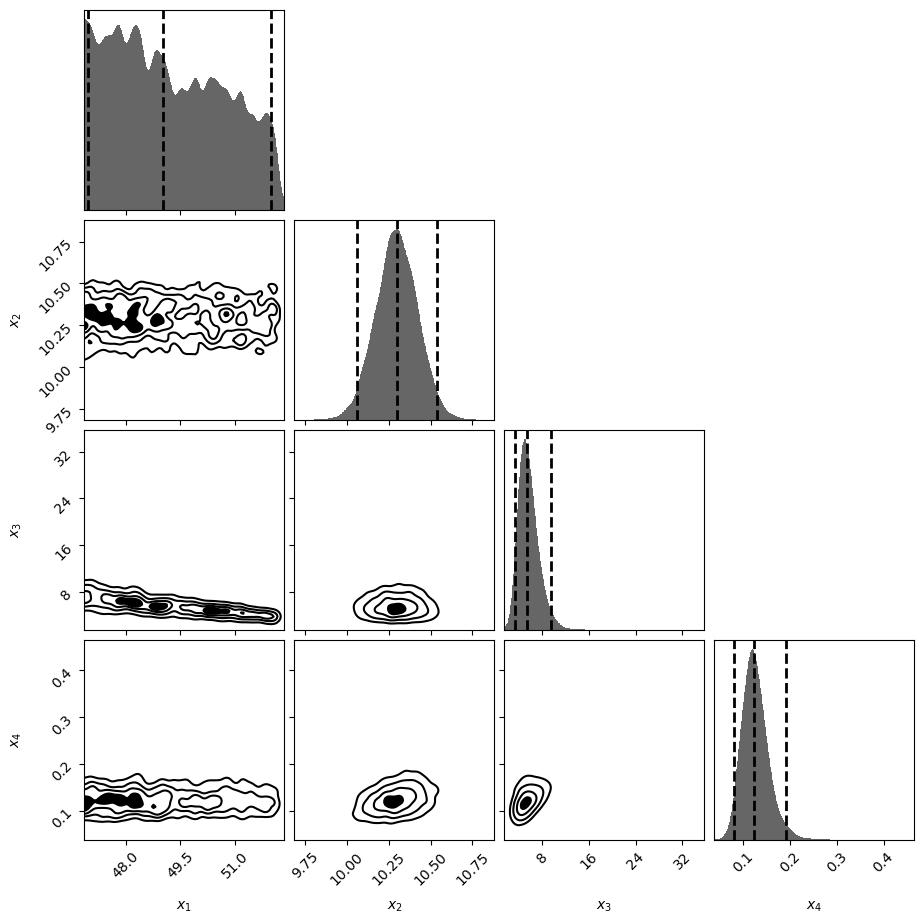

In [58]:
cfig, caxes = dyplot.cornerplot(sresults)

We now want to repeat the same process for the gaussian profile and compare the evidence to see which model fits the data best.

In [55]:
gsampler = dynesty.NestedSampler(loglikelihood, ptform, ndim, logl_args=[data,'gauss_profile'],ptform_args=['gauss_profile'], nlive = 500)
gsampler.run_nested()
gresults = gsampler.results

3861it [01:31, 14.08it/s, bound: 60 | nc: 192 | ncall: 62443 | eff(%):  6.183 | loglstar:   -inf < -86.783 <    inf | logz: -95.722 +/-  0.125 | dlogz: 33.239 >  0.509]     C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider

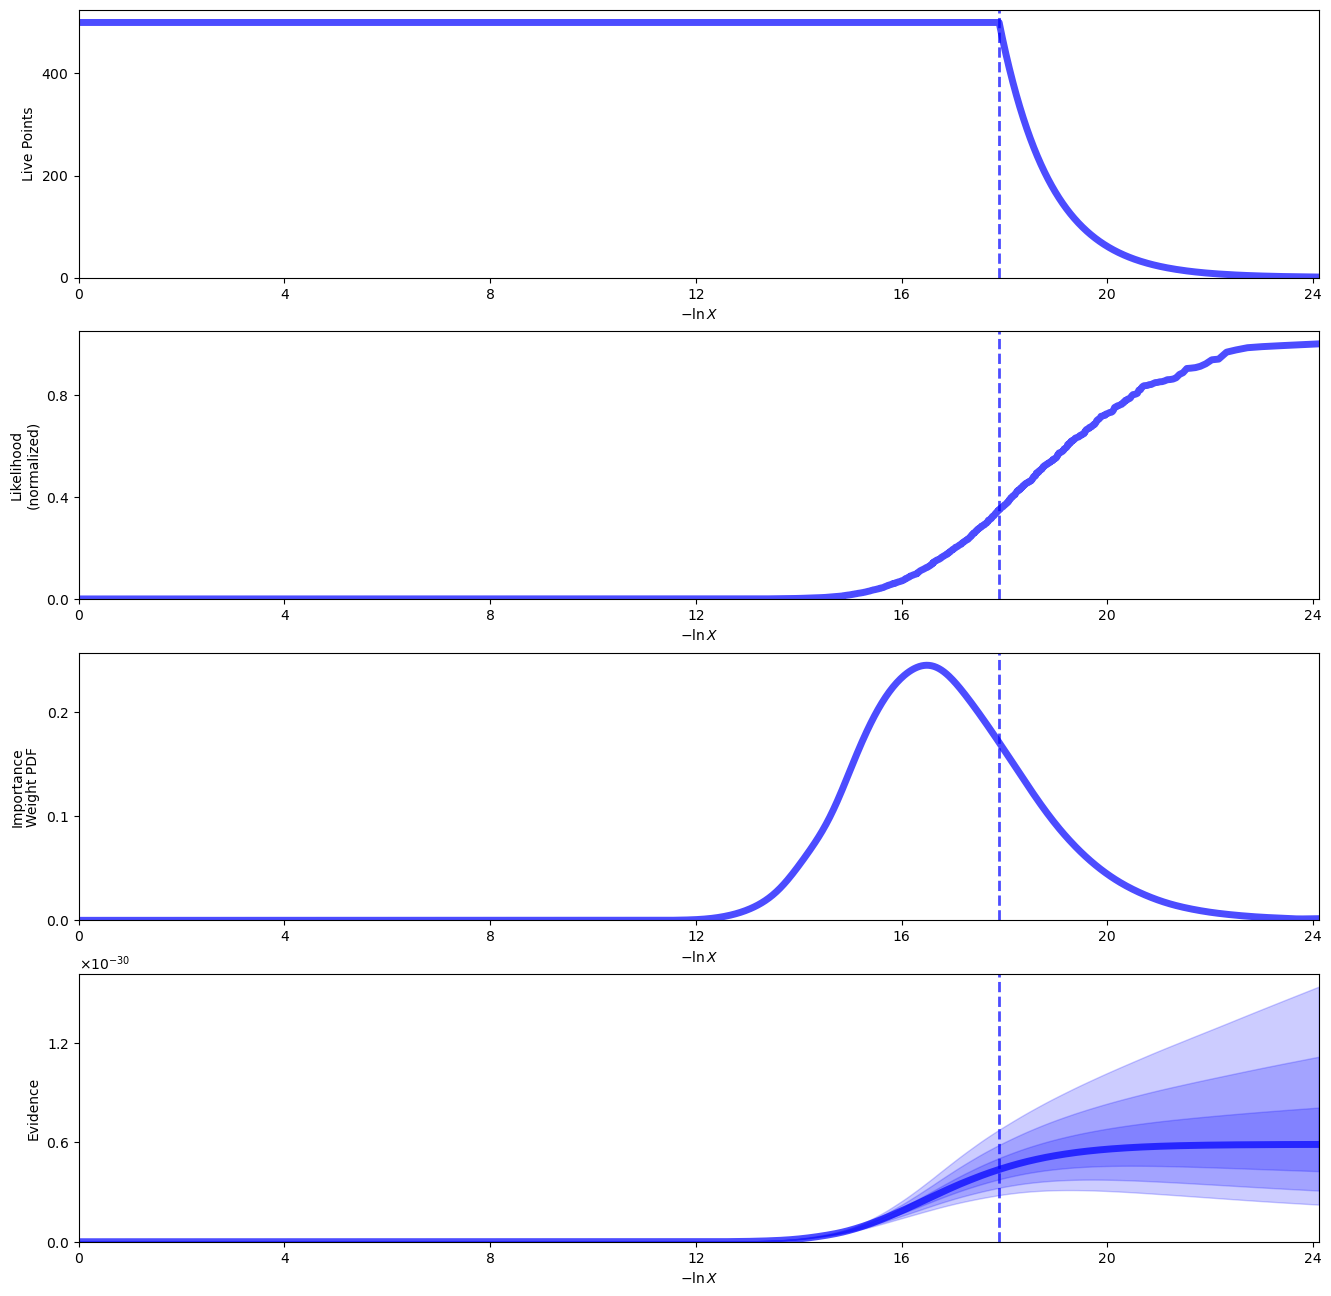

In [56]:
rgfig, rgaxes = dyplot.runplot(gresults)

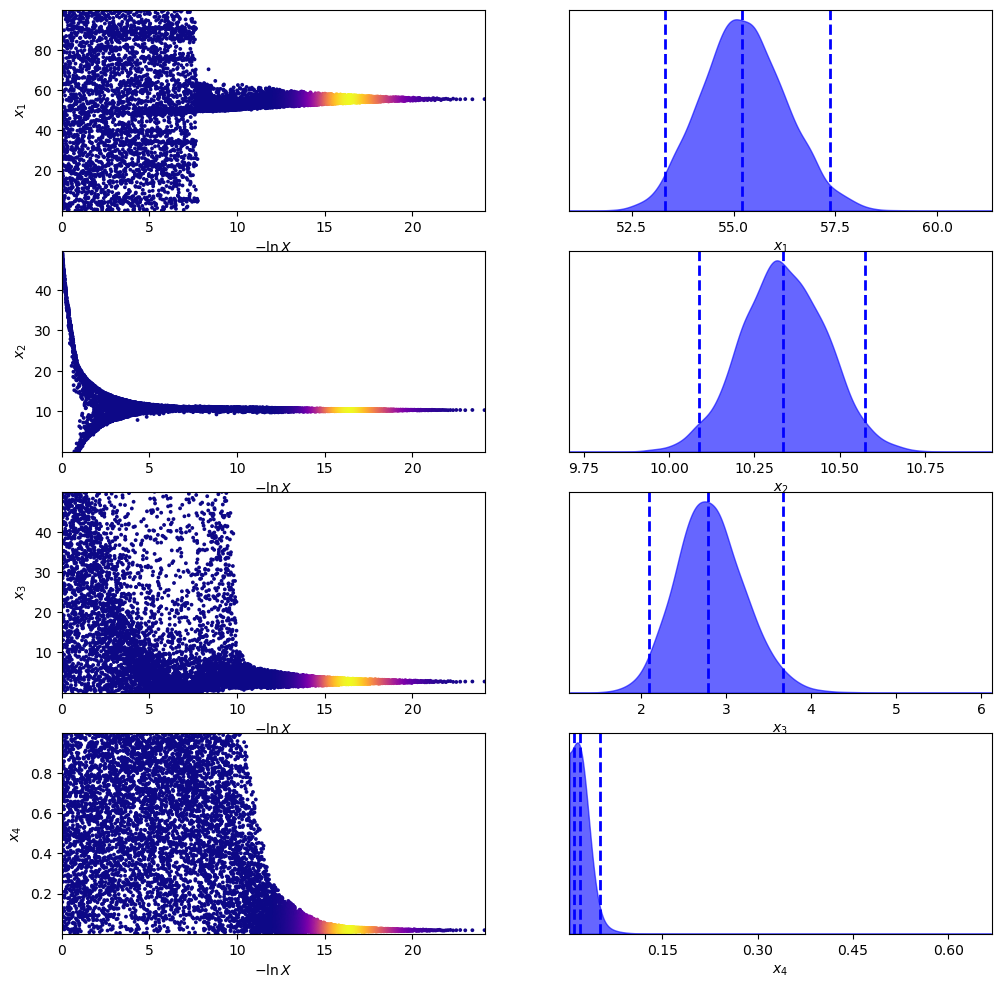

In [57]:
tgfig, tgaxes = dyplot.traceplot(gresults)

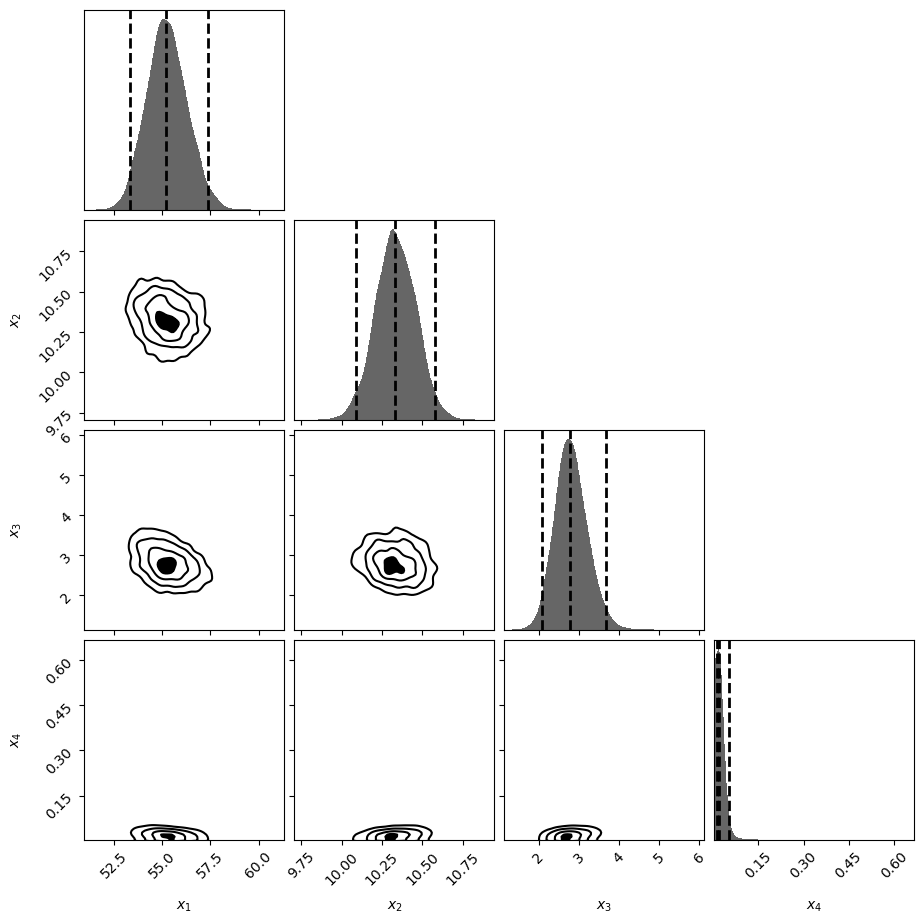

In [59]:
cgfig, cgaxes = dyplot.cornerplot(gresults)

### Evidence

In [60]:
sresults.summary()

Summary
nlive: 500
niter: 7666
ncall: 146997
eff(%):  5.555
logz: -63.305 +/-  0.298


In [61]:
gresults.summary()

Summary
nlive: 500
niter: 8956
ncall: 138931
eff(%):  6.806
logz: -69.608 +/-  0.321


In [86]:
logz_b = np.array([sresults.logz[-1], sresults.logzerr[-1]])
logz_g = np.array([gresults.logz[-1], gresults.logzerr[-1]])

zerr_b = logz_b[1] * np.exp(logz_b[0])
zerr_g = logz_g[1] * np.exp(logz_g[0])
print('burst evidence: ', np.exp(logz_b[0]), ' +/- ', zerr_b, '\ngauss profile evidence: ', np.exp(logz_g[0]), ' +/- ', zerr_g)

burst evidence:  3.2144115706126288e-28  +/-  9.571544153038175e-29 
gauss profile evidence:  5.881387861482636e-31  +/-  1.8897753179712987e-31


In [87]:
z_err = np.sqrt((zerr_b / np.exp(logz_b[0]))**2 + ((np.exp(logz_b[0]) * zerr_g)/np.exp(logz_g[0])**2)**2)

print('odds ratio: ', np.exp(logz_b[0])/ np.exp(logz_g[0]), ' +/- ', z_err)

odds ratio:  546.539634235636  +/-  175.61137271756562


The error of the odds ratio is found through error propagation:

$$\Delta f = \sqrt{\sum_{i=1}^{N}\left(\frac{df}{dx_i} \cdot \Delta x_i\right)^2}$$

The odds ratio points to the burst model to be the best between the two. Since it is larger than $10^2$, accourding to Jeffrey's scale it is **decisive** evidence.